#### Trial

In [2]:
s1_hr = pd.read_csv('data/S1/Final/hr.csv', header=None)
s1_hr.columns = ['x', 'y', 'z']
s1_hr

,x,y,z
0,1.544027e+09,1.544027e+09,1.544027e+09
1,3.200000e+01,3.200000e+01,3.200000e+01
2,-3.000000e+00,6.500000e+01,6.000000e+00
3,-3.000000e+00,6.500000e+01,6.000000e+00
4,-3.000000e+00,6.500000e+01,6.000000e+00
...,...,...,...
748683,-2.400000e+01,4.200000e+01,4.200000e+01
748684,-2.400000e+01,4.200000e+01,4.300000e+01
748685,-2.500000e+01,4.200000e+01,4.200000e+01
748686,-2.400000e+01,4.200000e+01,4.400000e+01


In [3]:
timestamp = s1_hr.iloc[0, 0]  # Given Unix timestamp
utc_time = datetime.fromtimestamp(timestamp, tz=timezone.utc)
utc_time

datetime.datetime(2018, 12, 5, 16, 28, 57, tzinfo=datetime.timezone.utc)

In [4]:
session_start_unix = s1_hr.iloc[0, 0]
sample_rate = s1_hr.iloc[1, 0]
print("Sample Rate:", sample_rate)

session_start_dt = datetime.fromtimestamp(session_start_unix, tz=timezone.utc)
exam_start_dt = session_start_dt.replace(hour=session_start_dt.hour+1, minute=0, second=0, microsecond=0)
print("Session Start Datetime:", session_start_dt)
print("Exam Start Datetime:", exam_start_dt)


# Convert exam start time to Unix timestamp
exam_start_time = int(exam_start_dt.timestamp())

# Define other key timestamps
halfway_time = exam_start_time + (10_800 / 2)  # Halfway (1.5 hours after exam start)
exam_end_time = exam_start_time + 10_800  # Exam end (3 hours after exam start)

# Compute actual timestamps for each row
s1_hr = s1_hr.iloc[2:].reset_index(drop=True)  # Remove first two rows (start time & sample rate)
s1_hr['Timestamp'] = session_start_unix + (s1_hr.index / sample_rate)  # Convert row index to actual timestamps


conditions = [
    (s1_hr['Timestamp'] < exam_start_time),
    (s1_hr['Timestamp'] >= exam_start_time) & (s1_hr['Timestamp'] < halfway_time),
    (s1_hr['Timestamp'] >= halfway_time) & (s1_hr['Timestamp'] < exam_end_time),
    (s1_hr['Timestamp'] >= exam_end_time),
]

labels = ['0-Before Exam', '1-Exam Start to Halfway', '2-Halfway to Exam End', '3-After Exam']

# Assign segment labels
s1_hr['Segment'] = np.select(conditions, labels)

s1_hr

Sample Rate: 32.0
Session Start Datetime: 2018-12-05 16:28:57+00:00
Exam Start Datetime: 2018-12-05 17:00:00+00:00


,x,y,z,Timestamp,Segment
0,-3.0,65.0,6.0,1.544027e+09,0-Before Exam
1,-3.0,65.0,6.0,1.544027e+09,0-Before Exam
2,-3.0,65.0,6.0,1.544027e+09,0-Before Exam
3,-3.0,65.0,6.0,1.544027e+09,0-Before Exam
4,-3.0,65.0,6.0,1.544027e+09,0-Before Exam
...,...,...,...,...,...
748681,-24.0,42.0,42.0,1.544051e+09,3-After Exam
748682,-24.0,42.0,43.0,1.544051e+09,3-After Exam
748683,-25.0,42.0,42.0,1.544051e+09,3-After Exam
748684,-24.0,42.0,44.0,1.544051e+09,3-After Exam


In [5]:
conver = 9.81 / 64 # convert to m/s^2
s1_hr['A_total'] = np.sqrt(s1_hr.iloc[:, 0]**2 + s1_hr.iloc[:, 1]**2 + s1_hr.iloc[:, 2]**2) * conver
s1_hr['Second'] = s1_hr.index // (60*sample_rate) + 1

In [6]:
s1_hr = s1_hr.groupby('Second')['A_total'].mean().reset_index()

In [7]:
s1_hr

,Second,A_total
0,1.0,10.014775
1,2.0,9.704139
2,3.0,9.673967
3,4.0,9.625669
4,5.0,9.692663
...,...,...
385,386.0,9.603256
386,387.0,9.601805
387,388.0,9.603073
388,389.0,9.602685


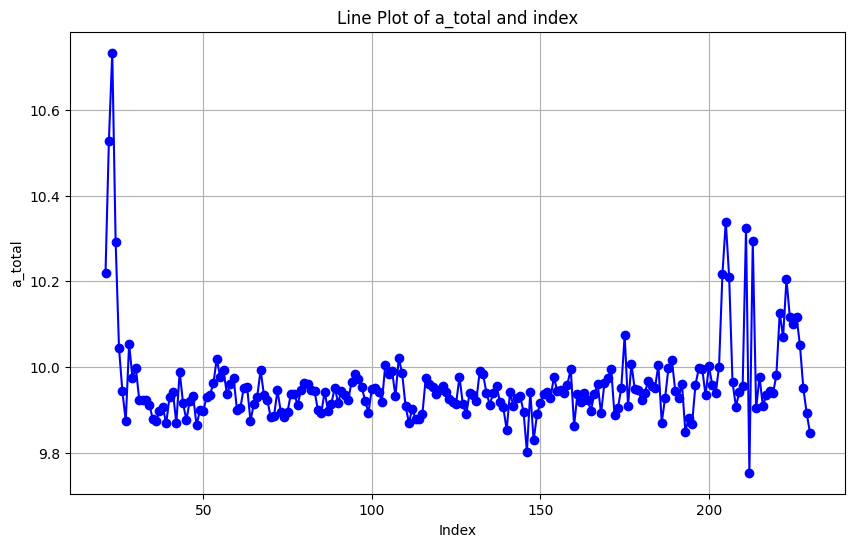

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(s1_hr['Second'][20:230], s1_hr['A_total'][20:230], marker='o', linestyle='-', color='b')
plt.title('Line Plot of a_total and index')
plt.xlabel('Index')
plt.ylabel('a_total')
plt.grid(True)
plt.show()

In [9]:
conver = 9.81 / 64 # convert to m/s^2
s1_hr['A_total'] = np.sqrt(s1_hr.iloc[:, 0]**2 + s1_hr.iloc[:, 1]**2 + s1_hr.iloc[:, 2]**2) * conver
s1_hr.groupby('Segment', observed=True)['A_total'].mean()

IndexError: single positional indexer is out-of-bounds

#### Func

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone

In [18]:
def get_data(sid, exam, time_adjustment=1):
    hr = pd.read_csv(f'data/{sid}/{exam}/HR.csv', header=None)
    hr.columns = ['x']
    
    session_start_unix = hr.iloc[0, 0]
    sample_rate = hr.iloc[1, 0]
    
    session_start_dt = datetime.fromtimestamp(session_start_unix, tz=timezone.utc)
    exam_start_dt = session_start_dt.replace(hour=session_start_dt.hour+time_adjustment, minute=0, second=0, microsecond=0)
    exam_start_time = int(exam_start_dt.timestamp())
    if exam == 'Final':
        time_1 = exam_start_time + (10_800 / 3)  # 1/3 (1 hour after exam start)
        time_2 = time_1 + (10_800 / 3) # 2/3 (2 hours after exam start)
        time_3 = exam_start_time + 10_800  # Exam end (3 hours after exam start)
    else:
        time_1 = exam_start_time + (5400 / 3)  # 1/3 (1 hour after exam start)
        time_2 = time_1 + (5400 / 3) # 2/3 (2 hours after exam start)
        time_3 = exam_start_time + 5400 
    
    hr = hr.iloc[2:].reset_index(drop=True)  # Remove first two rows (start time & sample rate)
    hr['Timestamp'] = session_start_unix + (hr.index / sample_rate)
    
    conditions = [
    (hr['Timestamp'] < exam_start_time),
    (hr['Timestamp'] >= exam_start_time) & (hr['Timestamp'] < time_1),
    (hr['Timestamp'] >= time_1) & (hr['Timestamp'] < time_2),
    (hr['Timestamp'] >= time_2) & (hr['Timestamp'] < time_3),
    (hr['Timestamp'] >= time_3),
    ]

    labels = ['0-Before Exam', '1-One Third (During)', '2-Two Third (During)', '3-Three Third (During)', '4-After Exam']

    hr['Segment'] = np.select(conditions, labels, default='0')

    hr[f'{sid}_{exam}'] = hr.iloc[:, 0]
    return hr.groupby('Segment')[f'{sid}_{exam}'].mean().reset_index()
    

In [19]:
def time_check(sid, exam):
    hr = pd.read_csv(f'data/{sid}/{exam}/hr.csv', header=None)
    hr.columns = ['x', 'y', 'z'] 
    print(datetime.fromtimestamp(hr.iloc[0, 0], tz=timezone.utc))

In [20]:
all_data = [(sid, exam) for sid in [f"S{i}" for i in range(1, 11)] for exam in ['Final', 'Midterm 1', 'Midterm 2']]

In [21]:
index = 0
for sid, exam in all_data:
    if index == 0:
        all_exam_data = get_data(sid, exam)
        index += 1
    else:
        all_exam_data = all_exam_data.merge(get_data(sid, exam), on='Segment')

In [31]:
df_transposed = all_exam_data.T
df_transposed.columns = df_transposed.iloc[0]  # Assign first row as column headers
df_transposed = df_transposed[1:].reset_index(drop=True)  # Remove the old first row
df_transposed

Segment,0-Before Exam,1-One Third (During),2-Two Third (During),3-Three Third (During),4-After Exam
0,105.638586,97.257044,91.072486,91.932128,118.983926
1,137.944643,123.298956,123.649339,81.888633,95.378065
2,118.700238,96.655489,102.290339,102.915378,122.311765
3,107.800358,108.004592,106.531633,100.037369,134.476
4,110.665469,142.095233,145.844156,91.688439,98.623163
5,122.041129,94.903244,92.074128,94.118444,111.848741
6,100.976918,87.405814,86.265675,84.746258,120.089512
7,170.922692,130.156394,100.855644,87.334494,103.537253
8,100.290963,90.554128,91.526689,85.494178,113.901532
9,94.572403,78.024214,81.224564,88.247189,125.302071


In [26]:
grade = pd.read_csv('data/ParsedGrades.csv')
grade['name'] = grade['Student'] + '_' + grade['Exam']

def normalize_grades(row):
    return row['Score'] / 200 if row['Exam'] == 'Final' else row['Score'] / 100

# Apply the function to each row
normalized_df = grade.set_index("name").apply(normalize_grades, axis=1).reset_index()
normalized_df.columns = ['Name', 'Percentage_Score']
normalized_df

,Name,Percentage_Score
0,S1_Midterm 1,0.780
1,S2_Midterm 1,0.820
2,S3_Midterm 1,0.770
3,S4_Midterm 1,0.750
4,S5_Midterm 1,0.670
5,S6_Midterm 1,0.710
6,S7_Midterm 1,0.640
7,S8_Midterm 1,0.920
8,S9_Midterm 1,0.800
9,S10_Midterm 1,0.890


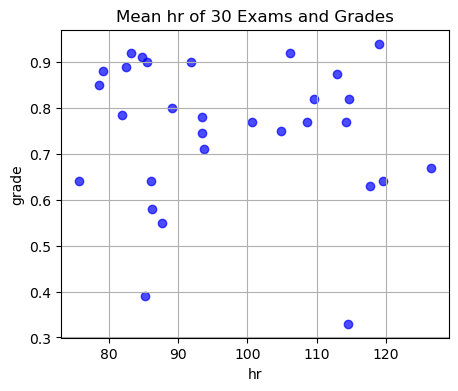

In [27]:
import matplotlib.pyplot as plt

three_means = (df_transposed['1-One Third (During)']+df_transposed['2-Two Third (During)']+df_transposed['3-Three Third (During)'])/3

plt.figure(figsize=(5, 4))
plt.scatter(three_means, normalized_df['Percentage_Score'], color='blue', marker='o', alpha=0.7)
plt.title('Mean hr of 30 Exams and Grades')
plt.xlabel('hr')
plt.ylabel('grade')
plt.grid(True)
plt.show()

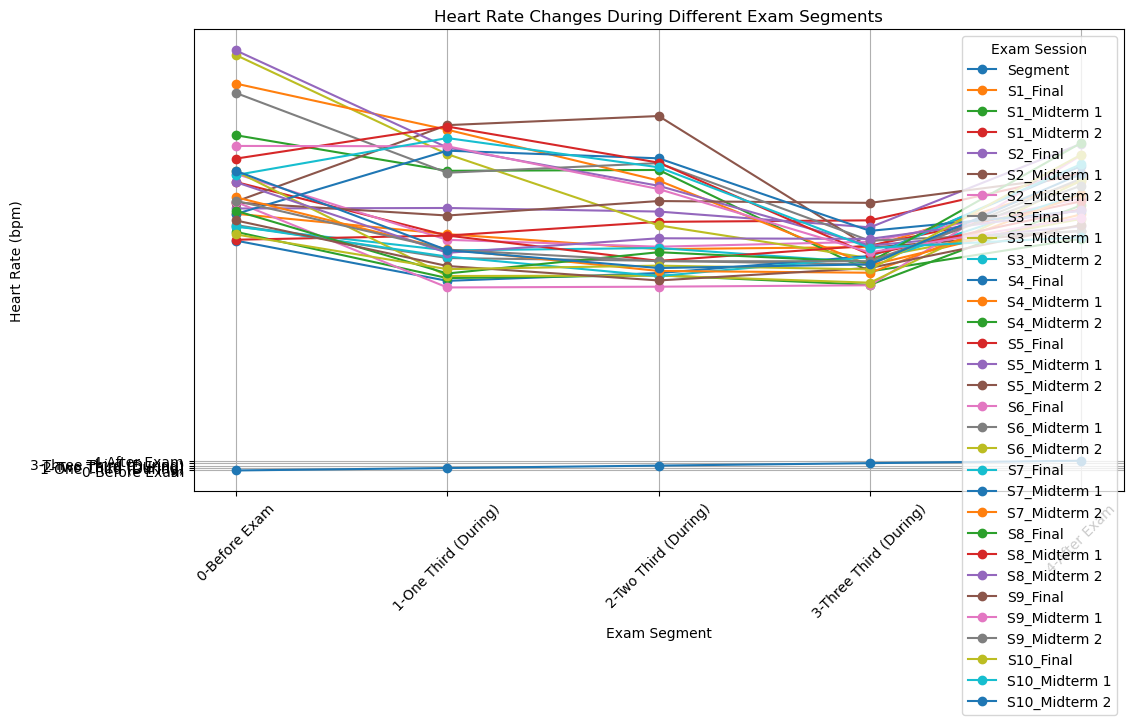

In [35]:
# Set the 'Segment' column as the index to facilitate plotting
# df_transposed.set_index('Segment', inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
for column in all_exam_data.columns:
    plt.plot(all_exam_data['Segment'], all_exam_data[column], marker='o', label=column)

plt.title('Heart Rate Changes During Different Exam Segments')
plt.xlabel('Exam Segment')
plt.ylabel('Heart Rate (bpm)')
plt.legend(title='Exam Session')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate segment labels for better visibility
plt.show()

In [34]:
all_exam_data

,Segment,S1_Final,S1_Midterm 1,S1_Midterm 2,S2_Final,S2_Midterm 1,S2_Midterm 2,S3_Final,S3_Midterm 1,S3_Midterm 2,...,S7_Midterm 2,S8_Final,S8_Midterm 1,S8_Midterm 2,S9_Final,S9_Midterm 1,S9_Midterm 2,S10_Final,S10_Midterm 1,S10_Midterm 2
0,0-Before Exam,105.638586,137.944643,118.700238,107.800358,110.665469,122.041129,100.976918,170.922692,100.290963,...,112.416625,106.847898,128.321000,118.640622,102.880288,133.533867,110.969988,97.112091,121.559887,123.284751
1,1-One Third (During),97.257044,123.298956,96.655489,108.004592,142.095233,94.903244,87.405814,130.156394,90.554128,...,90.976211,81.054283,141.519122,89.564822,84.121486,133.400739,90.859672,82.836611,136.781994,90.645756
2,2-Two Third (During),91.072486,123.649339,102.290339,106.531633,145.844156,92.074128,86.265675,100.855644,91.526689,...,82.094611,89.805436,126.660750,95.537633,78.181417,115.791661,86.105500,84.279269,124.752750,83.294322
3,3-Three Third (During),91.932128,81.888633,102.915378,100.037369,91.688439,94.118444,84.746258,87.334494,85.494178,...,81.362211,85.758906,88.778756,95.300000,83.332758,89.716161,86.087500,82.726914,91.539333,84.806572
4,4-After Exam,118.983926,95.378065,122.311765,134.476000,98.623163,111.848741,120.089512,103.537253,113.901532,...,113.676397,134.824144,107.516514,106.975401,101.050238,104.014331,117.225440,129.993466,95.984447,122.070899


In [38]:
df_transposed.to_csv('hr.csv', index=False)